In [18]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q


fatal: destination path 'medical-ai' already exists and is not an empty directory.


In [19]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [20]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [21]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found")
  assert (n > 0)

In [22]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)

TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [23]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

In [25]:
#Preparing Data

rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [26]:
# copy images to new directories for training purposes

for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("finish moving "+str(n*2)+" images to positive and negative folders.")

finish moving 292 images to positive and negative folders.


In [27]:
#load images into memory for visualization

positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

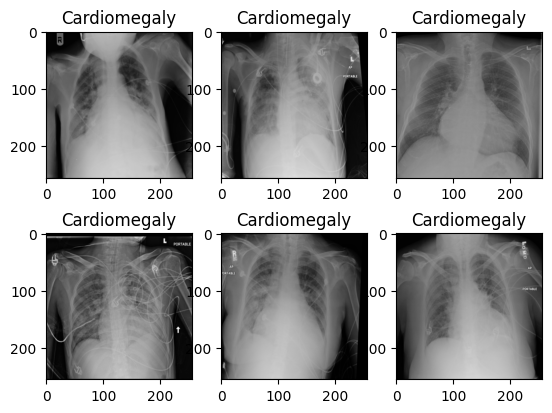

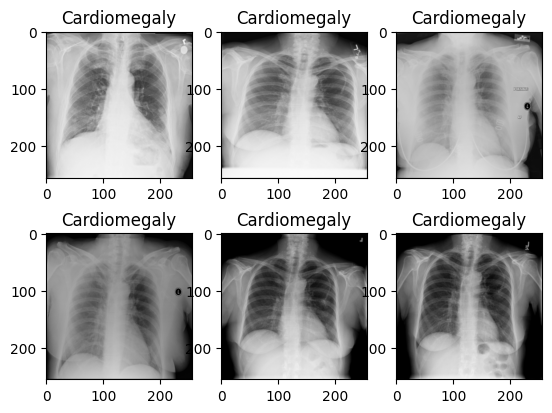

In [28]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(negative_imgs[idx])
plt.show()

In [29]:
#training the model

pre_trained_model = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top= False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = layers.Flatten()(last_output) #flatten the output layer to 1 dimension
x = layers.Dense(1024, activation='relu')(x) #add a fully connected layer with 1,024 hidden units and relu activation
x = layers.Dropout(0.2)(x) #add dropout rate of 0.2
x = layers.Dense(1, activation='sigmoid')(x) #add a final sigmoid layer for classification

model = Model(pre_trained_model.input, x) #configure and compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print("finish compiling the model")

finish compiling the model


In [30]:
#define our example directories and files

base_dir = rootdir = "/content/medical-ai/images"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [31]:
#add our data augmentation parameters to imagedatagenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

val_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode='binary')

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode='binary')

train_steps = len(os.listdir(train_pos_dir)) * 2
test_steps = len(os.listdir(test_pos_dir)) * 2

print("Completed")

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Completed


In [33]:
#run model

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_steps,
    verbose=2)

Epoch 1/20
232/232 - 661s - loss: 13.7396 - acc: 0.5603 - val_loss: 1.9099 - val_acc: 0.6333 - 661s/epoch - 3s/step
Epoch 2/20
232/232 - 758s - loss: 3.5705 - acc: 0.6121 - val_loss: 1.9212 - val_acc: 0.6667 - 758s/epoch - 3s/step
Epoch 3/20
232/232 - 660s - loss: 1.7446 - acc: 0.6293 - val_loss: 0.7525 - val_acc: 0.6833 - 660s/epoch - 3s/step
Epoch 4/20
232/232 - 647s - loss: 0.6030 - acc: 0.7241 - val_loss: 0.8382 - val_acc: 0.6333 - 647s/epoch - 3s/step
Epoch 5/20
232/232 - 683s - loss: 0.5585 - acc: 0.7241 - val_loss: 0.4642 - val_acc: 0.7667 - 683s/epoch - 3s/step
Epoch 6/20
232/232 - 735s - loss: 0.5928 - acc: 0.7069 - val_loss: 0.9825 - val_acc: 0.5333 - 735s/epoch - 3s/step
Epoch 7/20
232/232 - 689s - loss: 0.4984 - acc: 0.7543 - val_loss: 0.6708 - val_acc: 0.7000 - 689s/epoch - 3s/step
Epoch 8/20
232/232 - 715s - loss: 0.4073 - acc: 0.8190 - val_loss: 0.6605 - val_acc: 0.7333 - 715s/epoch - 3s/step
Epoch 9/20
232/232 - 748s - loss: 0.5538 - acc: 0.7241 - val_loss: 0.4693 - val

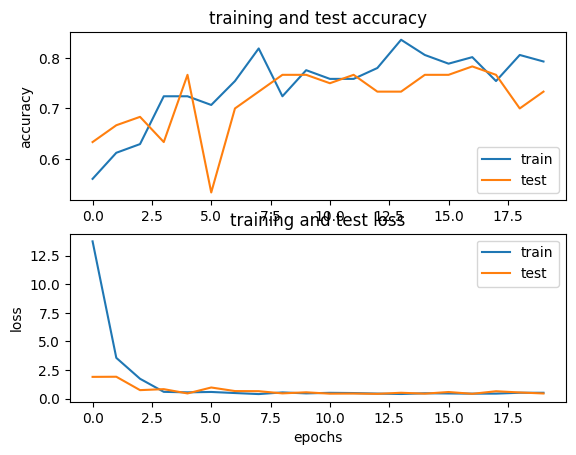

In [35]:
#plot the training and test loss and accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("accuracy")
plt.title("training and test accuracy")
plt.legend(loc="lower right")

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("training and test loss")
plt.legend(loc="upper right")

plt.show()

In [43]:
#evaluating performance

def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  exp = np.true_divide(image_np, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  exp = np.true_divide(img, 255.0)
  expanded = np.expand_dims(exp, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [44]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath", "filename", "label", "guess", "confidence"])

print("complete interface")

1/1 [==============================] - 0s 254ms/step
complete interface


In [45]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/p...,00013615_052.jpg,pos,pos,0.992227
1,/content/medical-ai/images/Cardiomegaly/test/p...,00025969_000.jpg,pos,pos,0.974444
2,/content/medical-ai/images/Cardiomegaly/test/p...,00010381_000.jpg,pos,pos,0.972232
3,/content/medical-ai/images/Cardiomegaly/test/p...,00004893_085.jpg,pos,pos,0.947334
4,/content/medical-ai/images/Cardiomegaly/test/p...,00004344_013.jpg,pos,pos,0.920110


1/1 [==============================] - 0s 237ms/step


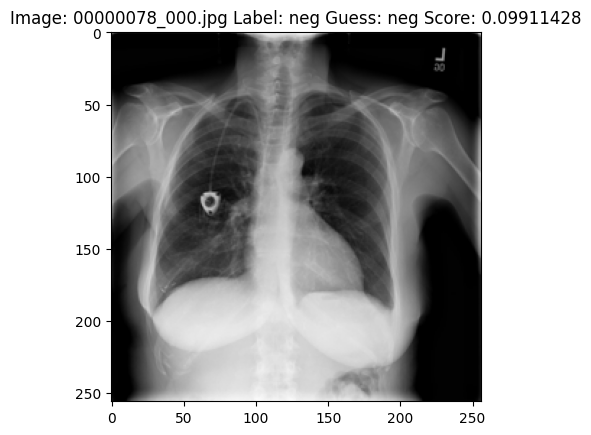

In [46]:
#example image

import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

In [47]:
#table of images

df[::5][['filename', 'label', "guess", "confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.992227
5,00030206_013.jpg,pos,pos,0.912625
10,00000094_000.jpg,neg,pos,0.818743
15,00012686_003.jpg,pos,pos,0.747284
20,00028607_000.jpg,pos,pos,0.639335
25,00000090_006.jpg,neg,pos,0.558362
30,00000083_000.jpg,neg,neg,0.329796
35,00015719_005.jpg,pos,neg,0.222678
40,00015064_001.jpg,pos,neg,0.167078
45,00000091_007.jpg,neg,neg,0.074161


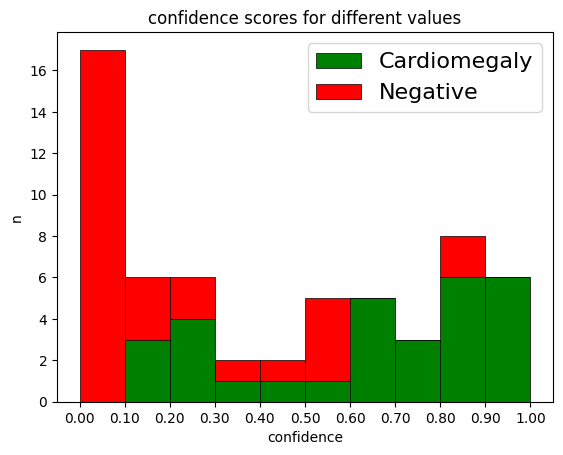

In [48]:
#histogram

from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos, neg], np. arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5,
                            density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('confidence')
plt.ylabel('n')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('confidence scores for different values')
plt.legend(loc="upper right", fontsize=16)
plt.show()

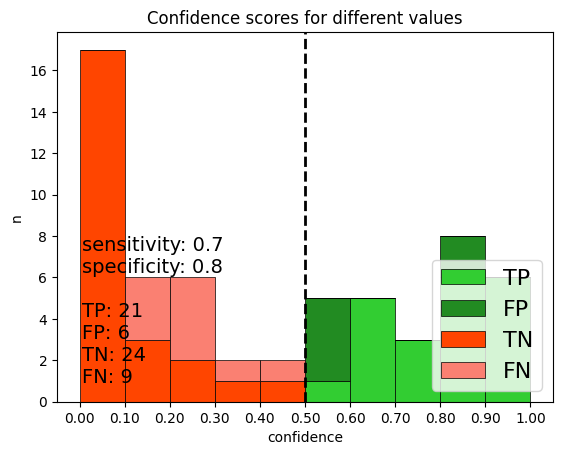

In [58]:
#cutoff point

def create_with_cutoff(cutoff):
  __, ax = plt.subplots()
  TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
  FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
  FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
  TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]
  plt.hist([TP,FP,TN,FN], np.arange(0.0, 1.1, 0.1).tolist(), \
           edgecolor='black', linewidth=0.5, density=False, histtype='bar', \
           stacked=True, color=['limegreen','forestgreen','orangered','salmon'], \
           label=['TP','FP','TN','FN'])
  plt.xlabel('confidence')
  plt.ylabel('n')
  plt.xticks(bins)
  ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
  plt.title('Confidence scores for different values')
  plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
  plt.legend(loc="lower right", fontsize=16)
  sens = round(len(TP)/(len(TP)+len(FN)),2)
  spec = round(len(TN)/(len(TN)+len(FP)),2)
  stats = "sensitivity: "+str(sens)+"\n"+"specificity: "+str(spec)+"\n\n"+"TP: "+str(len(TP))+"\n"+"FP: "+str(len(FP))+"\n"+"TN: "+str(len(TN))+"\n"+"FN: "+str(len(FN))
  plt.text(0.05, 0.05, stats, fontsize=14, transform=ax.transAxes)
  plt.show()

create_with_cutoff(cutoff=0.5)

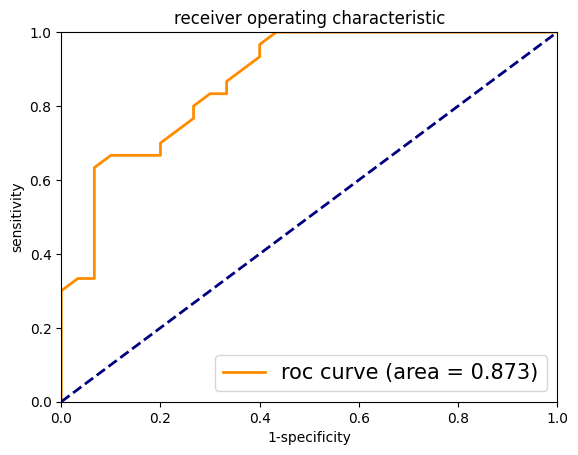

In [66]:
#roc curve

def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='roc curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('sensitivity')
plt.xlabel('1-specificity')
plt.title('receiver operating characteristic')
plt.legend(loc="lower right", fontsize=15)
plt.show()

In [67]:
#save model

model.save('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}

  adding: content/export/Cardiomegaly/ (stored 0%)
  adding: content/export/Cardiomegaly/saved_model.pb (deflated 92%)
  adding: content/export/Cardiomegaly/assets/ (stored 0%)
  adding: content/export/Cardiomegaly/fingerprint.pb (stored 0%)
  adding: content/export/Cardiomegaly/keras_metadata.pb (deflated 96%)
  adding: content/export/Cardiomegaly/variables/ (stored 0%)
  adding: content/export/Cardiomegaly/variables/variables.index (deflated 78%)
  adding: content/export/Cardiomegaly/variables/variables.data-00000-of-00001 (deflated 42%)
